
--- TESTE: UCB CLÁSSICO (is_monotonic=False) ---

             RESULTADOS FINAIS (UCB CLÁSSICO)
Braço 1: Jogadas: 41, Média: 0.2706
Braço 2: Jogadas: 69, Média: 0.4028
Braço 3: Jogadas: 109, Média: 0.4963
Braço 4: Jogadas: 209, Média: 0.5967
Braço 5: Jogadas: 572, Média: 0.6988
Recompensa Total: 617.42


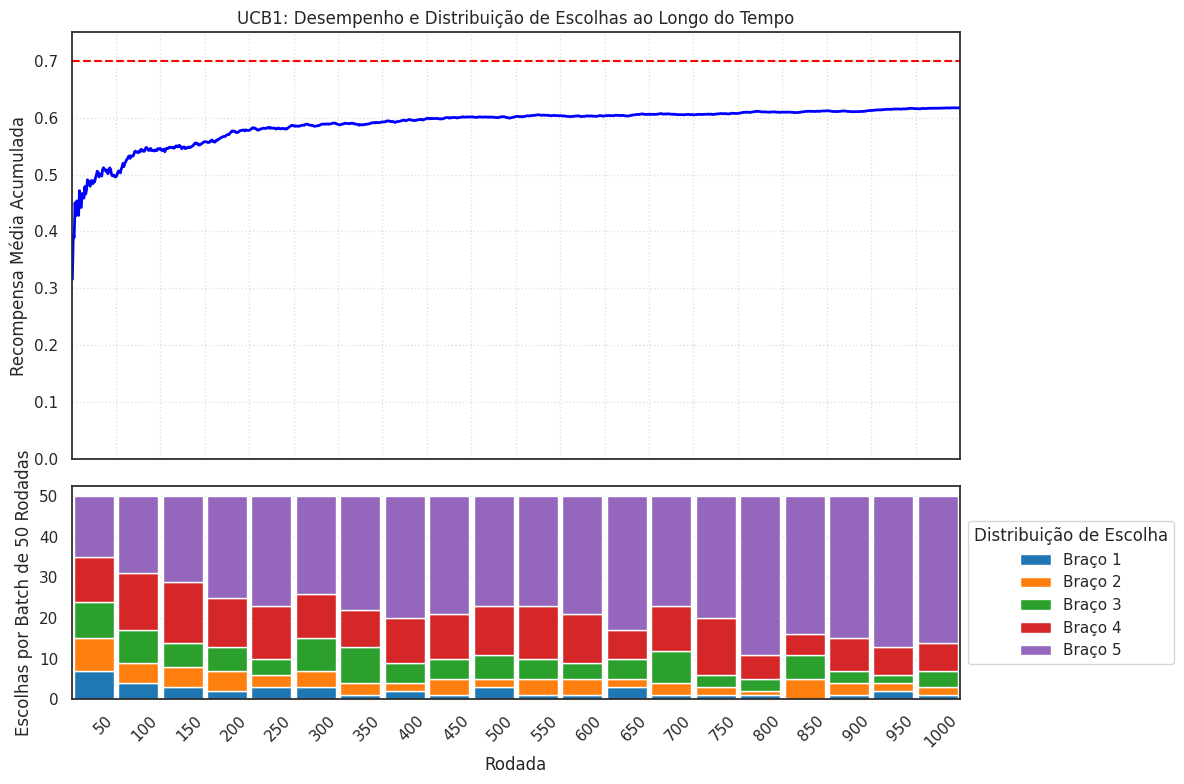

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

# ====================================================================
# 1. FUNÇÃO DO ALGORITMO UCB1 (CLÁSSICO)
# ====================================================================

def ucb1_m_algorithm_for_plotting(K, N, reward_functions, is_monotonic=False):
    """
    Executa o algoritmo UCB1 ou UCB1-M, registrando o histórico de recompensas
    e braços selecionados para plotagem.
    """
    # 1. Inicialização
    plays_per_arm = np.zeros(K)
    total_rewards = np.zeros(K)
    total_reward_accumulated = 0

    reward_history = []
    arm_history = []  # Armazena o índice do braço selecionado (0 a K-1)

    # 2. Fase de Exploração Inicial (t = 1 até K)
    for t in range(1, K + 1):
        arm_index = t - 1
        reward = reward_functions[arm_index]()

        plays_per_arm[arm_index] += 1
        total_rewards[arm_index] += reward
        total_reward_accumulated += reward
        reward_history.append(reward)
        arm_history.append(arm_index)

    # 3. Fase de Exploração/Explotação (t = K+1 até N)
    for t in range(K + 1, N + 1):
        ucb_values = np.zeros(K)

        # Calcular u_{i,t} (Upper Bound) para cada braço
        for i in range(K):
            if plays_per_arm[i] == 0:
                ucb_values[i] = float('inf')
                continue

            avg_reward = total_rewards[i] / plays_per_arm[i]

            # --- FÓRMULA DE EXPLORAÇÃO ---
            if not is_monotonic:
                # UCB1 CLÁSSICO: sqrt(2 * log(t) / T_i)
                exploration_term = math.sqrt( (2 * math.log(t)) / plays_per_arm[i] )
                current_ucb = avg_reward + exploration_term
            else:
                # UCB1-M: (Fórmula incompleta no prompt original, mas mantida para monotonicidade)
                exploration_term = math.sqrt((4 * math.log(t) + math.log(i + 1)) / (2 * plays_per_arm[i]))
                current_ucb = avg_reward + exploration_term
            # ----------------------------------------

            if is_monotonic:
                # Aplica o Minimização de Monotonicidade (UCB1-M)
                ucb1_m_value = current_ucb
                for j in range(i + 1):
                    if plays_per_arm[j] == 0:
                        j_ucb = float('inf')
                    else:
                        j_avg_reward = total_rewards[j] / plays_per_arm[j]
                        j_exploration_term = math.sqrt((4 * math.log(t) + math.log(j + 1)) / (2 * plays_per_arm[j]))
                        j_ucb = j_avg_reward + j_exploration_term
                    if j_ucb < ucb1_m_value:
                        ucb1_m_value = j_ucb
                ucb_values[i] = ucb1_m_value
            else:
                # UCB Padrão
                ucb_values[i] = current_ucb

        # Seleção e Atualização
        best_arm_index = np.argmax(ucb_values)
        reward = reward_functions[best_arm_index]()

        plays_per_arm[best_arm_index] += 1
        total_rewards[best_arm_index] += reward
        total_reward_accumulated += reward
        reward_history.append(reward)
        arm_history.append(best_arm_index)

    # 4. Resultado Final
    average_rewards = total_rewards / plays_per_arm

    return total_reward_accumulated, plays_per_arm, average_rewards, reward_history, arm_history

# ====================================================================
# 2. DEFINIÇÃO E EXECUÇÃO
# ====================================================================

# 1. Definição dos Parâmetros e Recompensas
NUM_ARMS = 5
NUM_ROUNDS = 1000
# Recompensas Médias (Média: 0.3, 0.4, 0.5, 0.6, 0.7)
REWARD_FUNCTIONS = [
    lambda: np.random.beta(3, 7),  # Braço 1 (Média: 0.3)
    lambda: np.random.beta(4, 6),  # Braço 2 (Média: 0.4)
    lambda: np.random.beta(5, 5),  # Braço 3 (Média: 0.5)
    lambda: np.random.beta(6, 4),  # Braço 4 (Média: 0.6)
    lambda: np.random.beta(7, 3)   # Braço 5 (Média: 0.7 - O melhor)
]

# Definição das cores para os braços (K=5)
ARM_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# 2. Execução
print("\n--- TESTE: UCB CLÁSSICO (is_monotonic=False) ---")
(total_reward, plays, avg_rewards, reward_history, arm_history) = ucb1_m_algorithm_for_plotting(
    K=NUM_ARMS,
    N=NUM_ROUNDS,
    reward_functions=REWARD_FUNCTIONS,
    is_monotonic=False # UCB1 CLÁSSICO
)

# 3. Impressão dos Resultados
print("\n" + "="*40)
print("             RESULTADOS FINAIS (UCB CLÁSSICO)")
print("="*40)
for i in range(NUM_ARMS):
    print(f"Braço {i+1}: Jogadas: {int(plays[i])}, Média: {avg_rewards[i]:.4f}")
print(f"Recompensa Total: {total_reward:.2f}")
print("="*40)

# ====================================================================
# 3. GERAÇÃO DO GRÁFICO (LINHA + BARRAS EMPILHADAS)
# ====================================================================

# Dados para plotagem
rounds = range(1, NUM_ROUNDS + 1)
cumulative_rewards = np.cumsum(reward_history)
average_cumulative_rewards = cumulative_rewards / rounds
theoretical_best_avg = 7 / (7 + 3) # Média do braço 5 = 0.7

# --- CÁLCULO PARA O GRÁFICO DE BARRAS EMPILHADAS ---
BATCH_SIZE = 50
num_batches = NUM_ROUNDS // BATCH_SIZE
batch_rounds = [i * BATCH_SIZE for i in range(1, num_batches + 1)]

# Armazena a contagem de escolhas por braço em cada batch
choice_counts_per_batch = np.zeros((num_batches, NUM_ARMS))

for i in range(num_batches):
    start_index = i * BATCH_SIZE
    end_index = start_index + BATCH_SIZE

    # Conta a ocorrência de cada braço no batch
    batch_history = arm_history[start_index:end_index]
    for arm_index in range(NUM_ARMS):
        choice_counts_per_batch[i, arm_index] = batch_history.count(arm_index)

# ----------------------------------------------------


# --- CRIAÇÃO DOS SUBPLOTS (Recompensa + Escolhas) ---
# Compartilha o eixo X
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                               gridspec_kw={'height_ratios': [2, 1]})

## --- 1. PLOT DA RECOMPENSA (AX1) ---
ax1.plot(rounds, average_cumulative_rewards, label='Recompensa Média Acumulada',
         color='blue', linewidth=2)
ax1.hlines(theoretical_best_avg, 1, NUM_ROUNDS, color='red', linestyle='--',
           label=f'Melhor Média Teórica ({theoretical_best_avg:.2f})')

ax1.set_title('UCB1: Desempenho e Distribuição de Escolhas ao Longo do Tempo')
ax1.set_ylabel('Recompensa Média Acumulada')
ax1.grid(True, linestyle=':', alpha=0.6)
#ax1.legend(loc='lower right')
ax1.set_ylim(0, 0.75)

## --- 2. PLOT DAS ESCOLHAS (AX2) ---
# Posições X para as barras (centro do batch)
x_positions = np.array(batch_rounds) - BATCH_SIZE / 2
bar_width = BATCH_SIZE * 0.9

# Plotagem das barras empilhadas
bottom = np.zeros(num_batches)
for arm_index in range(NUM_ARMS):
    counts = choice_counts_per_batch[:, arm_index]

    ax2.bar(x_positions, counts, width=bar_width, bottom=bottom,
            color=ARM_COLORS[arm_index], label=f'Braço {arm_index+1}', edgecolor='white')

    bottom += counts # Atualiza o 'bottom' para a próxima pilha

ax2.set_ylabel(f'Escolhas por Batch de {BATCH_SIZE} Rodadas')
ax2.set_xlabel('Rodada')
ax2.grid(axis='y', linestyle=':', alpha=0.6)
ax2.set_xticks(batch_rounds)
ax2.set_xticklabels(batch_rounds, rotation=45, ha="right")
ax2.set_xlim(0, NUM_ROUNDS)

# Adiciona a legenda separada para as cores dos braços
ax2.legend(title='Distribuição de Escolha', loc='center left', facecolor='white',bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

#print("\nGráfico gerado com sucesso!")
#print("O painel superior mostra a curva de aprendizado (recompensa acumulada).")


#print(f"O painel inferior mostra a distribuição das escolhas de braço a cada {BATCH_SIZE} rodadas.")

